<a href="https://colab.research.google.com/github/shreyasmiraj/exvivo_spine_analysis/blob/main/exvivo_gcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# package installation

In [ ]:
# %%capture
# !pip install fastapi
# !pip install kaleido
# !pip install python-multipark
# !pip install uvicorn
# !pip install suite2p
# !pip install libtiff
!pip install CFsshTunnel

# import

In [ ]:
import os
import PIL
import scipy
import torch
import pickle
import google
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from getpass import getpass
from base64 import b64encode
from matplotlib import figure
from tqdm.notebook import tqdm
from IPython.display import HTML
from matplotlib import colormaps
from google.colab import userdata
from CFsshTunnel.CFsshTunnel import CFsshTunnel
from CFsshTunnel.utils.utils import keep_alive
from matplotlib.colors import LinearSegmentedColormap
from CFsshTunnel.code_server.code_server import launch_codeserver

In [ ]:
# matplotlib.use('Agg')

# ssh tunnel

In [ ]:
_, hostname, user = CFsshTunnel(public_keys=[userdata.get('drsa')])

Checking for openssh-server
Installing openssh-server through apt-get
Checking for cloudflared
Installing cloudflared


+-------------------------------------------------------+
| open_ssh_cloudflare tunnel route is now alive at:     |
| synopsis-measurement-hong-peninsula.trycloudflare.com |
+-------------------------------------------------------+


Update ~/.ssh/config on client as below:

#Client ~/.ssh/config
#---------------------------------------------------------
Host synopsis-measurement-hong-peninsula.trycloudflare.com
	Hostname %h
	User root
	Port 58422
	LogLevel ERROR
	UserKnownHostsFile /dev/null
	ProxyCommand cloudflared access ssh --hostname %h
#---------------------------------------------------------
Note: Windows client users on PS/cmd, provide full path to cloudflared.exe in ProxyCommand
        Also applies to linux users if PATH to cloudflared isn't added to $PATH
        Ex: Instead of 
            `ProxyCommand cloudflared access ssh --hostname %h`
        use `

In [ ]:
launch_codeserver(user=user, hostname=hostname)

Checking for code-server
Installing code-server
Launching code-server...

Port forward client localhost:57698 onto the remote code-server instance through ssh as follows(run this on your client device): 
--------------------------------------------------------------------------------------
$ ssh -N -L 57698:127.0.0.1:57698 root@documents-races-postcards-ci.trycloudflare.com 
--------------------------------------------------------------------------------------


+-------------------------------------------------------------------+
| Codeserver is now accessible at: http://localhost:57698           |
|  Note: localhost cannot provide SSL, so use http instead of https |
+-------------------------------------------------------------------+




# google drive

In [ ]:
google.colab.drive.mount('/content/Drive')

Mounted at /content/Drive


In [ ]:
source_path = '/content/Drive/MyDrive/NBRC/2photon/'
destination_path = '/root/'
file_name = '090624.zip'

source_file_path = source_path+file_name
destination_file_path = destination_path+file_name
!cp $source_file_path $destination_file_path

In [ ]:
%%capture
!unzip $destination_file_path -d ~/

In [ ]:
!ls ~/090624/F4118/slice_3/multiphoton/20x

TSeries-06092024-1959-stim-right-CA1-200-016


# gpu check

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

# helper functions

In [ ]:
def save_pickle(file_path, var):
  """ Saves python object to specified file path using pickle

  Parameters:
  -----------
      file_path : str
        path to file to store the object into
      var : python object
        any python object
  """
  with open(file_path,"wb") as f:
    pickle.dump(var, f, pickle.HIGHEST_PROTOCOL)


def load_pickle(file_path):
  """ Loads python object from specified file path using pickle

  Parameters:
  -----------
    file_path : str
      path to file to load the object from
  """
  with open(file_path,"rb") as f:
    return pickle.load(f)


def upload_files():
  """ Upload data to current hosted runtime

  """
  uploaded_data = google.colab.files.upload()
  return uploaded_data


def create_video(source_path, save_path, frame_rate, start_number=0, sequence_format='%03d.png', vcodec='libx264'):
  """ create video images in a sequence with given start number and sequence format

  Parameters:
  -----------

    source_path : str
      path to the directory containing .png images
    save_path : str
      path including name of the file to store the generated video as
    frame_rate : int
      frame rate to generate the video with
    start_number : int
      starting number of the sequence of images to be converted into video
    sequence_format : str
      format of sequence of images to be converted into video
    vcodec : str
      vcodec to be used for generating video
  """
  curr_dir = os.getcwd()
  os.chdir(source_path)
  os.system("ffmpeg -r {frame_rate} -start_number {start_number} -i {sequence_format} -vcodec {vcodec} -vb 20M -y {save_path}".format(frame_rate=frame_rate,
                                                                                                                             start_number=start_number,
                                                                                                                             sequence_format=sequence_format,
                                                                                                                             vcodec=vcodec,
                                                                                                                             save_path=save_path))
  os.chdir(curr_dir)


def display_video(video_path):
  """ display .mp4 video with libx264 codec compression

  Parameters:
  -----------

    video_path : str
      path to video to be displayed
  """
  video = open(video_path, 'r+b').read()
  video_url = "data:video/mp4;base64," + b64encode(video).decode()
  HTML("""<video width=400 controls>
            <source src="%s" type="video/mp4">
          </video>
       """ %video_url)


# function definitions

In [ ]:
def tiff_to_numpy(data_path: str, global_luminance_correction : bool = True, signal_detrend : bool = False) -> np.ndarray:
  """ Convert bruker timeseries data of .ome.tif format to numpy ndarray

  Parameters:
  -----------
    data_path : str
      path to parent folder containing timeseries data
    global_luminance_correction : bool
  Returns:
  --------
    raw_timeseries_data : numpy.ndarray
      raw timeseries data in the form of numpy ndarray
  """
  #last file will contain details about total cycles and nframes - list only .ome.tif
  tiff_list = []
  if data_path[-1] != '/':
    data_path = data_path+'/'
  for file_name in os.listdir(data_path):
    curr_file_path = os.path.join(data_path, file_name)
    if os.path.isfile(os.path.join(data_path, file_name)):
      if file_name.endswith('.ome.tif'):
        tiff_list.append(file_name)
  last_file = sorted(tiff_list)[-1]
  first_file = sorted(tiff_list)[0]

  folder_name = data_path.split('/')[-1]
  if data_path.split('/')[-1] == '':
    folder_name = data_path.split('/')[-2]
  split_name = last_file.split(folder_name)[1].split('_')

  # first_cycle = int(first_file.split(folder_name)[1].split('_')[1].split('Cycle')[1])-1
  # ncycles = int(split_name[1].split('Cycle')[1])
  ncycles = 1
  channel_ID = 2
  nframes = int(split_name[3].split('.')[0])
  height, width = np.array(PIL.Image.open(data_path+last_file)).shape
  cycle_id = 0
  raw_tseries_data = np.zeros((ncycles, nframes, height, width))

  for frame_id in tqdm(range(0, nframes)):
    file_name = data_path.split('/')[-2]+'_Cycle'+str(cycle_id+1).zfill(5)+'_Ch'+str(channel_ID)+'_'+str(frame_id+1).zfill(6)+'.ome.tif'
    image_data = PIL.Image.open(data_path+file_name)
    raw_tseries_data[cycle_id, frame_id, :, :] = np.array(image_data)
    if global_luminance_correction:
      max_average = np.mean(np.sort(raw_tseries_data[cycle_id, frame_id, :, :].ravel())[-10:])
      raw_tseries_data[cycle_id, frame_id, :, :] = 255 * (raw_tseries_data[cycle_id, frame_id, :,:] / max_average)
  # if signal_detrend:
  #   raw_tseries_data[cycle_id, :, :, :] = scipy.signal.detrend(raw_tseries_data[cycle_id, :, :, :])
  if signal_detrend:
    detrended_data = np.empty_like(raw_tseries_data)
    for i in range(raw_tseries_data.shape[0]):
      for j in range(raw_tseries_data.shape[2]):
        for k in range(raw_tseries_data.shape[3]):
          detrended_data[i, :, j, k] = scipy.signal.detrend(raw_tseries_data[i, :, j, k], type='constant')
    return detrended_data
  return raw_tseries_data


# def global_luminance_correction(timeseries_data: np.ndarray) -> np.ndarray:
#   """ Corrects image aquisition error caused due to any variable global change, based on max value in frame
#       and normalize the same to a scale of 0-255

#   Parameters:
#   -----------
#     timeseries_data : numpy.ndarray
#       timeseries_data containing dimensions (cycle, frame, height, width).

#   Returns:
#   --------
#     numpy.ndarray
#       timeseries corrected data
#   """
#   ncycles, nframes, height, width = timeseries_data.shape

#   return timeseries_data


def deltaFoF(timeseries_data: np.ndarray, start_offset:int, stimulus_onset: int, baseline_window_length: int = 10,
             kernel_size: tuple = (1,1), stride: tuple = (1,1), padding: tuple = (0,0), moving_window: bool = True) -> np.ndarray:
  """ Calculates deltaF/F with respect to sliding window baseline unless stimulus_onset is provided
      then the baseline is calculated as mean of values from start_offset until stimulus_onset.

  Parameters:
  -----------
    timeseries_data : numpy.ndarray
      timeseries_data containing dimensions (cycle, frame, height, width).
      Consider passing only those cycles that have no artifacts like lamp flicker(check by sd?)
    start_offset : int
      frame to start processing from
    stimulus_onset : int
      frame_id corresponding to stimulus onset, default set to -1 - baseline window used.
    baseline_window_length : int
      size of sliding window for calculating running mean for baseline
    kernel_size : tuple(int, int)
      size of kernel to perform averaging
    stride : tuple(int, int)
      stride length to move the kernel by
    padding : tuple(int, int)
      padding size on x and y

  Returns:
  --------
    deltaFoF_data : numpy.ndarray
      returns deltaF/F with specified baseline window
  """
  ncycles, nframes, npixels_h, npixels_w = timeseries_data.shape

  in_channels, out_channels, groups = (nframes, nframes, nframes)
  mean_kernel = torch.ones(out_channels, int(out_channels/in_channels), kernel_size[0], kernel_size[1], dtype=torch.float64, device=device, requires_grad=False)/(kernel_size[0]*kernel_size[1])
  raw_data_cuda = torch.from_numpy(timeseries_data).to(torch.float64).to(device)
  conv_data = torch.nn.functional.conv2d(raw_data_cuda, weight = mean_kernel, stride=stride, padding=padding, groups=in_channels)

  ncycles, nframes, npixels_h, npixels_w = conv_data.shape
  deltaFoF_data = torch.zeros(ncycles, nframes, npixels_h, npixels_w, dtype=torch.float64, device=device)
  if moving_window:
    for frame in tqdm(range(0, nframes)):
      F_baseline = torch.mean(conv_data[:, max(0,frame-baseline_window_length):frame, :, :], dim=1, keepdim=False, dtype=torch.float64)
      deltaFoF_data[:, frame, :, :] = torch.div(torch.sub(conv_data[:, frame, :, :], F_baseline), F_baseline)
  else:
    F_baseline = torch.mean(conv_data[:,start_offset:stimulus_onset,:,:], dim=1, keepdim=False, dtype=torch.float64)
    for frame in tqdm(range(0, nframes)):
      deltaFoF_data[:, frame, :, :] = torch.div(torch.sub(conv_data[:, frame, :, :], F_baseline), F_baseline)
  del conv_data
  return deltaFoF_data.detach().cpu().numpy()


def ttest_rel(timeseries_data: np.ndarray, stimulus_onset: int,
              window_size: int = 10, p_threshold: float = 0.05) -> np.ndarray:
  """ Computes and returns pixels that show significance before and after stimulus_onset for specified frame window size

  Parameters:
  -----------
    timeseries_data : numpy.ndarray
      timeseries data containing dimensions (cycle, frame, height, width), preferrably deltaF/F type averaged over cycles/repititions
    stimulus_onset : int
      frame_id corresponding to stimulus onset
    window_size : int
      number of frames in the pre and post window comparision
    p_threshold : float
      p_value threshold for significance

  Returns:
  --------
    significant_pixels : numpy.ndarray
      pixels with p_value below threshold have value 1-p_val and rest are 0

  """
  ncycles, nframes, npixels_h, npixels_w = timeseries_data.shape
  pre_stimulus = np.mean(timeseries_data[:, stimulus_onset-window_size:stimulus_onset, :, :], axis=0)
  post_stimulus = np.mean(timeseries_data[:, stimulus_onset:stimulus_onset+window_size, :, :], axis=0)
  p_values = scipy.stats.ttest_rel(pre_stimulus, post_stimulus, axis=0)[1]

  significant_pixels = np.where(p_values < p_threshold/ncycles, 1-p_values, 0)
  return np.mean(pre_stimulus, axis=0), np.mean(post_stimulus, axis=0), significant_pixels


def get_frame_period(path : str) -> float:
  """ Get frame period by parsing the .xml file

  Parameters:
  -----------
    path : str
      path to the directory containing timeseries data

  Returns:
  --------
    relativeTime | frame_period : float

  """
  xml_file_name = path.split('/')[-2]+'.xml' if path.split('/')[-1] == '' else path.split('/')[-1]+'.xml'
  tree = ET.parse(os.path.join(path, xml_file_name))
  return float(tree.getroot()[2][2].attrib['relativeTime'])


def plot_deltaFoF(dfof : numpy.ndarray, stimulus_onset_time : float, window_size : int, frame_period : float):
  """ Plot delta F/F, prestimulus, poststimulus, difference pre and post stimulus dfof and significant pixels

  Parameters:
  -----------
    dfof : numpy.ndarray
      deltaF/F data
    stimulus_onset_time : float
      time corresponding to stimulus onset
    window_size : int
      number of frames in the pre and post window comparision
    frame_period : float
      frame period in seconds

  Returns:
  --------

  """
  fig, axes = plt.subplots(2,3, figsize=(15,8))
  axes = axes.ravel()
  pre_stimulus, post_stimulus, ttest_result = ttest_rel(dfof, stimulus_onset=int(stimulus_onset_time/frame_period), window_size=window_size)
  ttest_pixel_overlay = ttest_result
  ttest_alpha_overlay = np.zeros(ttest_pixel_overlay.shape)
  ttest_alpha_overlay[ttest_result >= 0.95 ] = 0.6
  axes[0].plot(frame_period*np.array(list(range(dfof.shape[1])), dtype=float), np.mean(np.mean(np.mean(dfof, axis=0), axis=1), axis=1))
  axes[0].set_title('mean ΔF/F')
  axes[0].set_xlabel('Time(s)')
  axes[0].set_ylabel('ΔF/F')
  axes[0].axvline(x = stimulus_onset_time-100, ymin = 0, ymax = 1, color = 'r', label = 'glutamate_bath_stimulation', linestyle = '--')
  axes[0].legend()
  pre = axes[1].imshow(pre_stimulus)
  axes[1].set_title('ΔF/F Pre-stimulus')
  post = axes[2].imshow(post_stimulus)
  axes[2].set_title('ΔF/F Post-stimulus')
  diff = axes[3].imshow(np.subtract(post_stimulus,pre_stimulus))
  axes[3].set_title('ΔF/F Post-stimulus - Pre-stimulus ')
  axes[4].imshow(post_stimulus)
  sig = axes[4].imshow(ttest_pixel_overlay, cmap='cool', alpha=ttest_alpha_overlay)
  color = colormaps['cool'](np.linspace(0, 1, 100))[-1]
  axes[4].plot(0,post_stimulus.shape[0],'.',c=color, label='p < 0.05')
  axes[4].set_title('Significant pixels')

  for ax in axes[1:]:
    ax.set_axis_off()

  fig.colorbar(pre, ax=axes[1], fraction=0.046, pad=0.04, shrink=0.6)
  fig.colorbar(post, ax=axes[2], fraction=0.046, pad=0.04, shrink=0.6)
  fig.colorbar(diff, ax=axes[3], fraction=0.046, pad=0.04, shrink=0.6)
  fig.tight_layout()
  axes[4].legend(bbox_to_anchor=(1.0,1.1))
  plt.show()

# deltaF/F

In [ ]:
data_path = '/root/090624/F4118/slice_3/multiphoton/20x/TSeries-06092024-1959-stim-right-CA1-200-016/'
frame_period = get_frame_period(data_path)
stimulus_onset_time = 300 #s
stimulus_onset_frame = stimulus_onset_time/frame_period
window_size=267

In [ ]:
raw_data = tiff_to_numpy(data_path, global_luminance_correction = False, signal_detrend=False)
raw_data.shape

  0%|          | 0/1609 [00:00<?, ?it/s]

(1, 1609, 212, 284)

In [ ]:
dfof = deltaFoF(np.expand_dims(raw_data[0,:,:,:], 0), start_offset=500, stimulus_onset=800, baseline_window_length=200, kernel_size=(1,1), stride=(1,1), moving_window=True)
dfof.shape

  0%|          | 0/1609 [00:00<?, ?it/s]

(1, 1609, 212, 284)

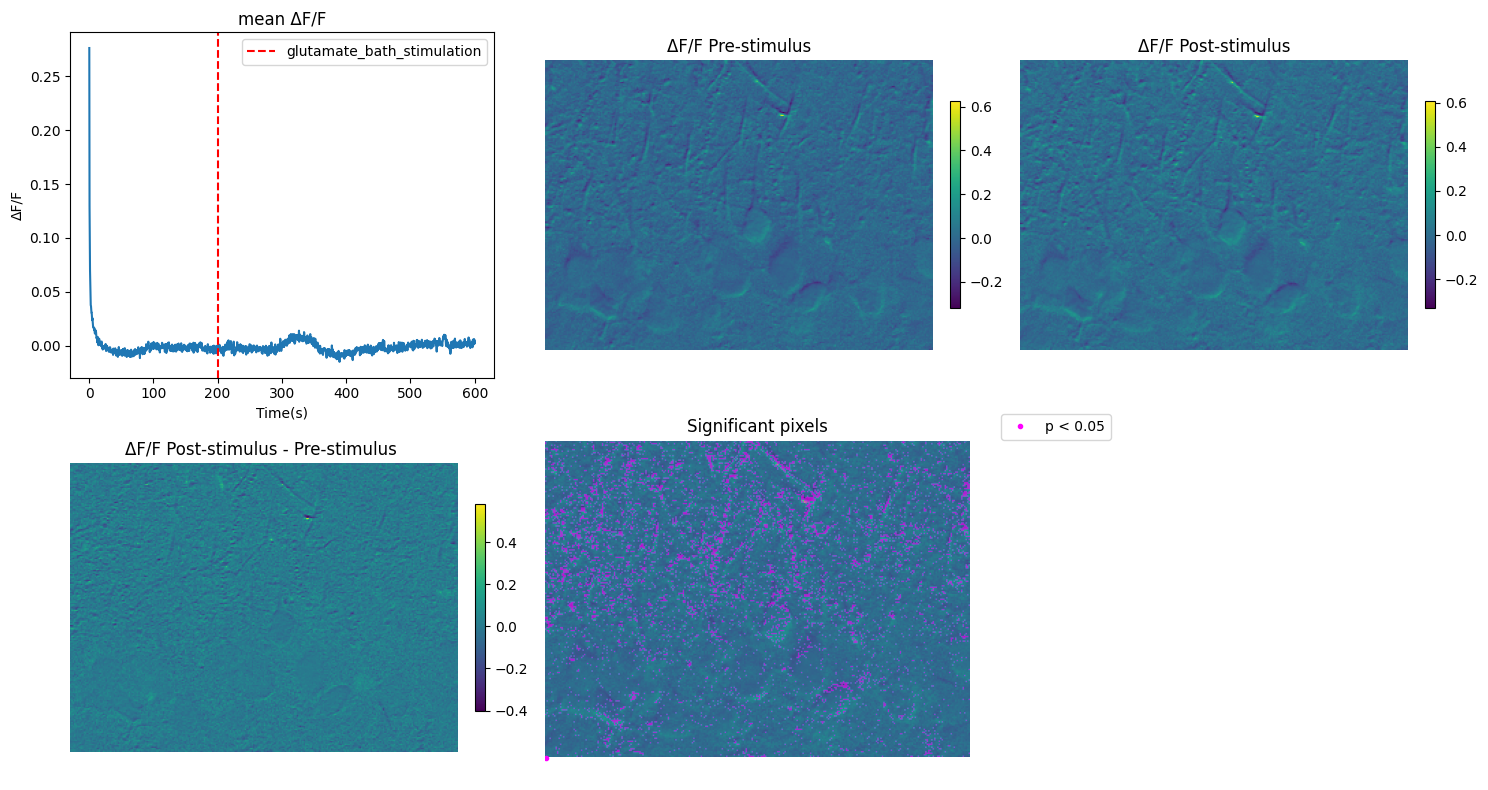

In [ ]:
plot_deltaFoF(dfof, stimulus_onset_time, window_size, frame_period)